In [26]:
import scipy.spatial as sspat
import numpy as np
from src.Dataset import Dataset
import scipy.interpolate as sintp
#from src.methods.neural_network_tools import deformation
import torch
import matplotlib.pyplot as plt
import scipy.ndimage as sim

In [27]:
dataset=Dataset("data/2022_03_21_1.h5")
dataset.open()

In [28]:
fr=dataset.get_frame(0)

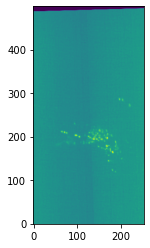

In [40]:
im=fr[0].max(2)
center=np.array(im.shape)/2-0.5
plt.imshow(im.T,origin="lower")

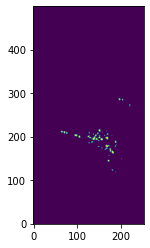

In [41]:
threshold=35
binmask=im>threshold
plt.imshow(binmask.T,origin="lower")

In [42]:
cm=sim.center_of_mass(im*binmask)
movementcm-center

array([ 22.25367447, -53.99923789])

In [25]:
dataset.close()

In [9]:
dataset=Dataset("/home/cfpark00/TrackingGUI/data/mili1-gt.h5")
dataset.open()
points=dataset.get_points()
dataset.close()

In [11]:
np.save("points.npy",points)

In [2]:
dataset=Dataset("/home/cfpark00/Projects/WormTracking/targettrack/data/184.h5")
dataset.open()
points=dataset.get_points()
dataset.close()

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/cfpark00/Projects/WormTracking/targettrack/data/184.h5', errno = 2, error message = 'No such file or directory', flags = 1, o_flags = 2)

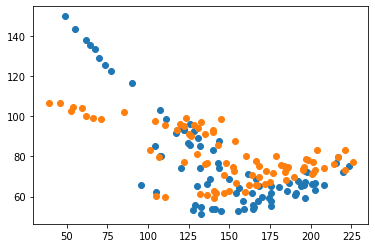

In [3]:
ptfrom=points[0]
ptto=points[100]
plt.scatter(*ptfrom[:,:2].T)
plt.scatter(*ptto[:,:2].T)

In [4]:
deformation,losses,msg=deformation.get_deformation(ptfrom,ptto,sh=(256,160,16),k_cut_dimless=2.5,lr=0.1,iterations=200,lambda_div=1,scale=(1,1,1),at_least=4,device="cuda",verbose=True,return_losses=True)

4.869450092315674
4.919613361358643
3.572965621948242
2.6245758533477783
2.8917317390441895
2.784406900405884
2.377760410308838
2.189540386199951
2.09248423576355
1.8094682693481445
1.604529619216919
1.5201798677444458
1.5096213817596436
1.475572943687439
1.4074437618255615
1.4056341648101807
1.409444808959961
1.3877288103103638
1.243016004562378
1.1371523141860962
1.0456931591033936
1.0602575540542603
1.031825304031372
1.0220222473144531
0.9543790817260742
0.9542558193206787
0.9625335335731506
0.9586924910545349
0.8873180150985718
0.8446359634399414
0.7950338125228882
0.7867451906204224
0.8079757690429688
0.7933118343353271
0.7538635730743408
0.7355953454971313
0.7380530834197998
0.7113739848136902
0.6954070329666138
0.6789027452468872
0.6751428842544556
0.6545417904853821
0.6609717011451721
0.6640117168426514
0.6332080960273743
0.6262078881263733
0.6198529005050659
0.6108863353729248
0.6228138208389282
0.5922449231147766
0.5897855162620544
0.579684853553772
0.5713846683502197
0.56620

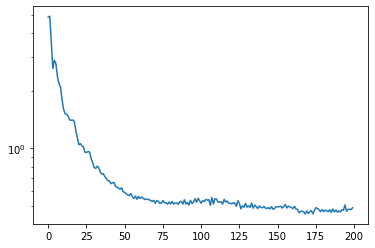

In [5]:
plt.plot(losses)
plt.yscale("log")

In [7]:
deformation.device

device(type='cuda', index=0)

In [34]:
import scipy.spatial as sspat
import numpy as np
from src.Dataset import Dataset
import scipy.interpolate as sintp

In [ ]:
points=np.load("./points.npy")
#ts=np.arange(len(points))
#f_intp=sintp.interp1d(ts,points,axis=0)
#ts_=np.linspace(0,len(points)-1,2500)
#points=f_intp(ts_)
#points=points[:,:,[1,0,2]]

In [ ]:
dataset=Dataset("./data/mili1.h5")
dataset.open()
dataset.set_data("points",points[:,:,[1,0,2]],compression=None,overwrite=True)
dataset.close()

In [ ]:
import scipy.spatial as sspat
import numpy as np

def interpolate_points(points,t_ref=0):
    """
    points (T,N+1,2) float32 : an array of coordinates for N points, np.nan where it doesn't exist, points[:,0] should be all nan
    t_ref reference time
    
    returns
    
    ptss (T,N+1,2) float32 an array of coordinates like points where coordinates for nans are interpolated
    """
    T=points.shape[0]
    points_ref=points[t_ref,1:]
    existing_ref=~np.isnan(points_ref[:,0])
    distmat=sspat.distance.squareform(sspat.distance.pdist(points_ref))
    np.fill_diagonal(distmat,np.nan)

    ptss=np.full_like(points,np.nan)
    for t in range(T):
        existing=~np.isnan(points[t,1:,0])
        if existing.sum()==0:
            pass
        todo=np.nonzero(~(existing*existing_ref))[0]
        for i in todo:
            validrefs=np.nonzero((~np.isnan(distmat[i]))*existing*existing_ref)[0]
            if len(validrefs)==0:
                continue
            weights=(1/(distmat[i,validrefs]+epsilon))**2
            vecs=points[t,validrefs+1,:2]-points_ref[validrefs,:2]
            vec=(weights[:,None]*vecs).sum(0)/weights.sum()
            ptss[t,1+i,:2]=points_ref[i]+vec
    return ptss

In [ ]:
ptss=interpolate_points(points[:,:,:2],t_ref=0)

In [ ]:
ptss.shape

In [ ]:
distmat=sspat.distance.squareform(sspat.distance.pdist(np.full((30,3),np.nan)))
distmat.shape